In [2]:
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir.parent)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim
import compare

C:\Users\pinak\Documents\GitHub\sphere-fp


In [4]:
# start simple make a Monte-Carlo plot for the staedy state
dim = 10
def mu(X):
    x, y, x1, y1, x2, y2, x3, y3, x4, y4 = tf.split(X, dim, axis=-1)
    z = 4. * (x*x + y*y - 1.0)
    z1 = 4. * (x1*x1 + y1*y1 - 1.0)
    z2 = 4. * (x2*x2 + y2*y2 - 1.0)
    z3 = 4. * (x3*x3 + y3*y3 - 1.0)
    z4 = 4. * (x4*x4 + y4*y4 - 1.0)
    return tf.concat([-x*z, -y*z, -x1*z1, -y1*z1, -x2*z2, -y2*z2, -x3*z3, -y3*z3, -x4*z4, -y4*z4], axis=-1).numpy()

sigma = np.sqrt(2.0)
N = int(1e6)
n_subdivs = 50
dt = 0.01
n_steps = 10
save_folder = '.'
X0 = tf.random.uniform(minval=-2., maxval=2., shape=(N, dim)).numpy()
mc = sim.MCProb(save_folder=save_folder, n_subdivs=n_subdivs, mu=mu, sigma=sigma, X0=X0)
mc.propagate(n_steps=n_steps, dt=dt)
# mc.compute_all(n_steps=n_steps, dt=dt)

Time taken by propagate is 11.853021144866943 seconds


In [6]:
# Now let's make the same plot from the network 
domain = mc.get_grid()
net = arch.LSTMForgetNet(num_nodes=50, num_blocks=3)
net.load_weights('../../data/{0}D/sphere{0}D'.format(dim)).expect_partial()
sol = lambda *args: tf.exp(net(*args))

def plot_solutions_3D(learned, resolution, low, high):
  fig = plt.figure(figsize=(8, 8))
  ax_l = fig.add_subplot(111, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_l = z_l/z_l.sum()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()

def plot_solutions_2D(learned, resolution, low, high):
  fig = plt.figure(figsize=(8, 8))
  ax_l = fig.add_subplot(111)
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_l = z_l/z_l.sum()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  im = ax_l.pcolormesh(x, y, z_l, cmap='inferno', shading='auto')
  fig.colorbar(im)
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  
# plot_solutions_3D(learned=sol, resolution=50, low=domain.mins, high=domain.maxs)
# plot_solutions_2D(learned=sol, resolution=50, low=domain.mins, high=domain.maxs)

<IPython.core.display.Javascript object>


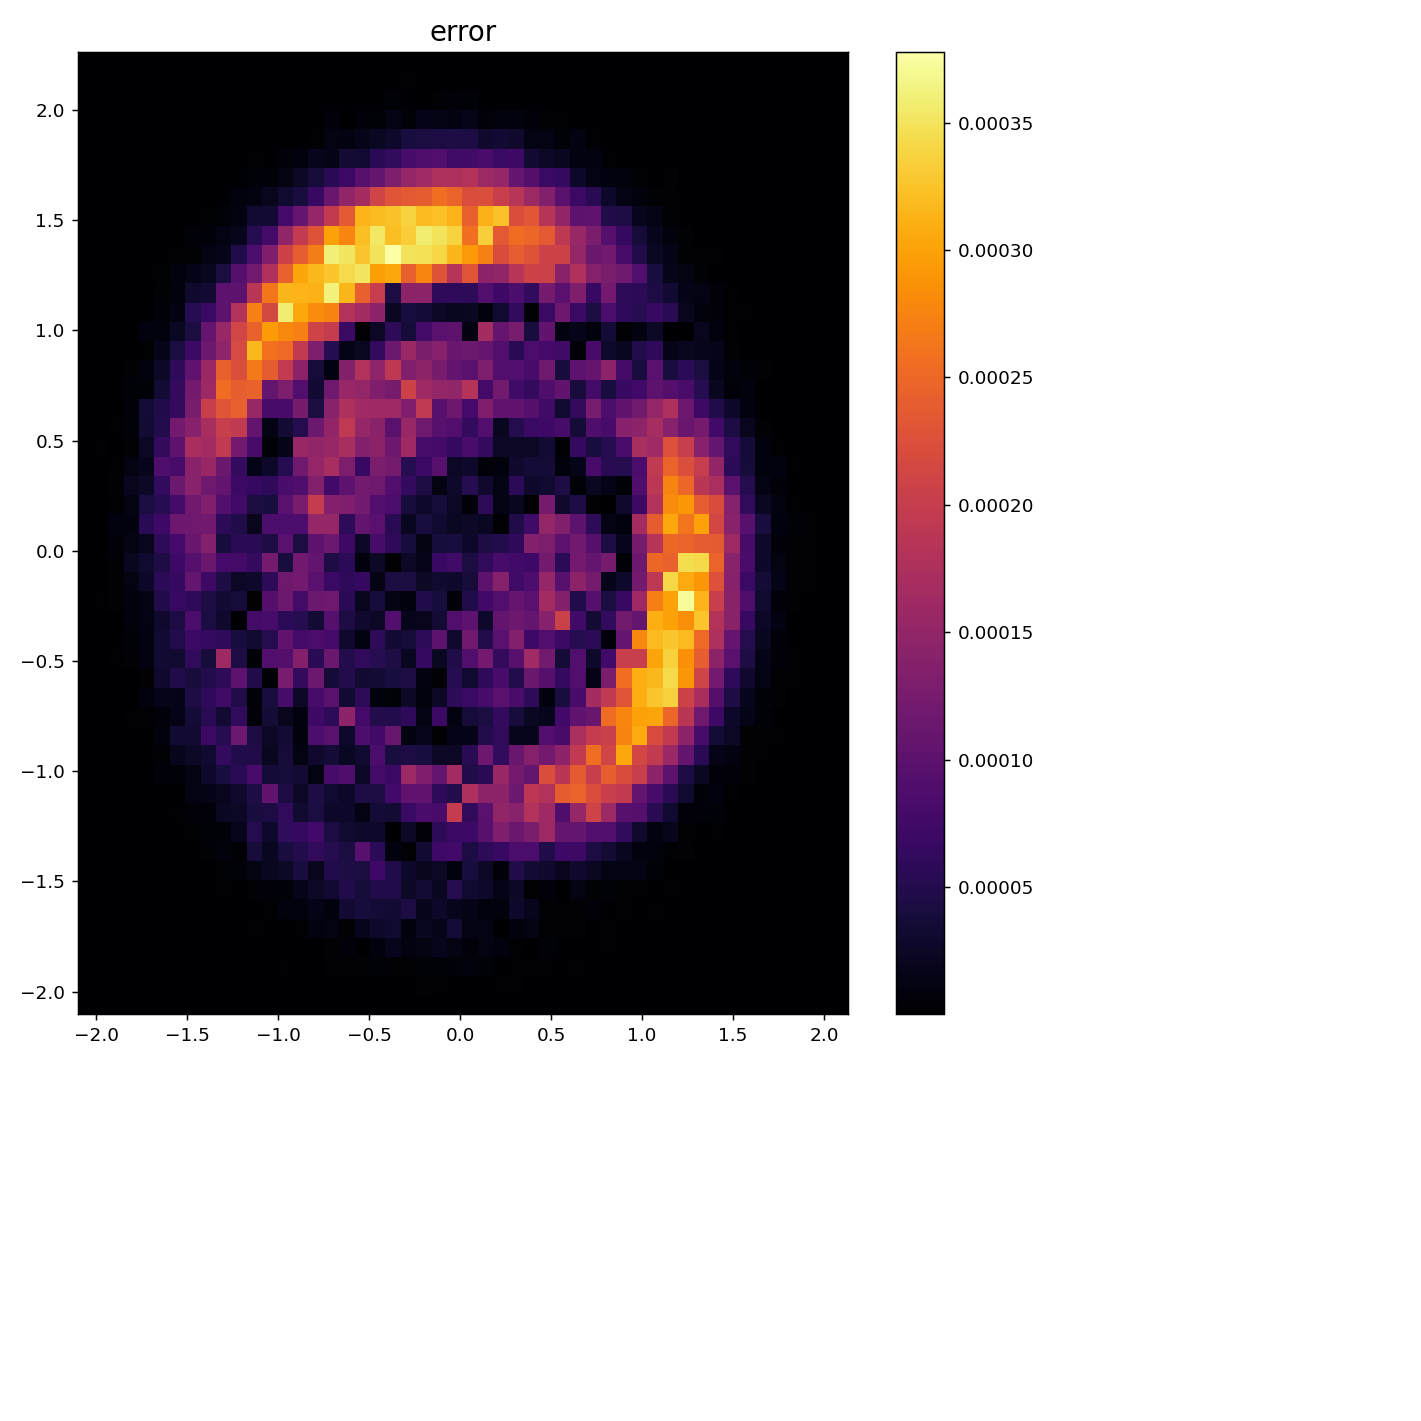

In [25]:
# level-up let's try to make an error plot 
i, j = 0, 1
coords = np.genfromtxt('{}/coordinates.csv'.format(save_folder), delimiter=',')
boxes, counts = np.unique(coords[:, [i, j]], return_counts=True, axis=0)
pd.DataFrame(boxes).to_csv('{}/boxes_{}_{}.csv'.format(save_folder, i, j), index=None, header=None)
pd.DataFrame(counts).to_csv('{}/counts_{}_{}.csv'.format(save_folder, i, j), index=None, header=None)
prob = np.zeros((mc.n_subdivs, mc.n_subdivs))
for k, b in enumerate(boxes):
    prob[int(b[0]), int(b[1])] = counts[k] 
prob /= np.sum(prob)

def plot_error(learned, resolution, low, high, mc_data):
  fig = plt.figure(figsize=(8, 8))
  ax_l = fig.add_subplot(111)
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_l = z_l/z_l.sum()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = np.abs(z_l.reshape(grid) - mc_data)
  im = ax_l.pcolormesh(x, y, z_l, cmap='inferno', shading='auto')
  fig.colorbar(im)
  ax_l.set_title('error', fontsize=15)
  plt.tight_layout()
  plt.show()

plot_error(learned=sol, resolution=50, low=domain.mins, high=domain.maxs, mc_data=prob)

In [24]:
prob.shape

(50, 50)

In [8]:
from scipy.special import erf
D = 1.0
def p_inf(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z



def plot_error_in_mc(learned, resolution, low, high, mc_data):
  fig = plt.figure(figsize=(8, 8))
  ax_l = fig.add_subplot(111)
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = p_inf(x, y).numpy()
  z_l = z_l/z_l.sum()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = np.abs(z_l.reshape(grid) - mc_data)
  im = ax_l.pcolormesh(x, y, z_l, cmap='inferno', shading='auto')
  fig.colorbar(im)
  ax_l.set_title('error', fontsize=15)
  plt.tight_layout()
  plt.show()

# plot_error_in_mc(learned=sol, resolution=50, low=domain.mins, high=domain.maxs, mc_data=prob)

<IPython.core.display.Javascript object>


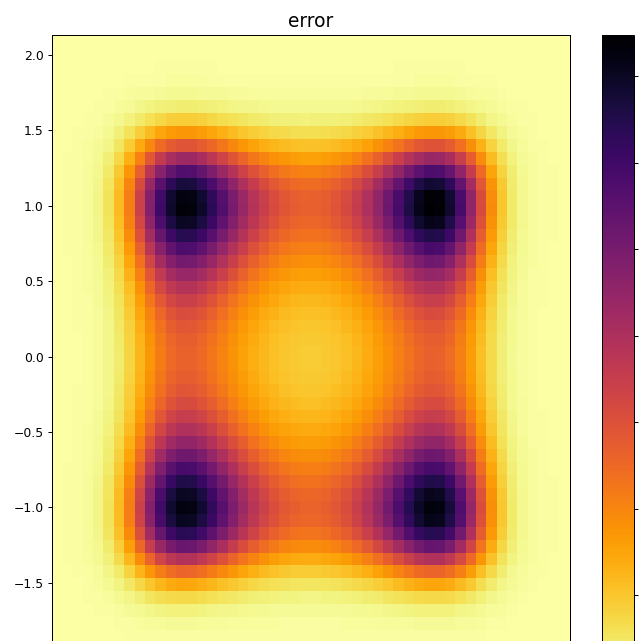

In [13]:
def plot_error_in_net(learned, resolution, low, high):
  fig = plt.figure(figsize=(8, 8))
  ax_l = fig.add_subplot(111)
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  truth = p_inf(x, tf.zeros_like(x)).numpy()*p_inf(y, tf.zeros_like(x)).numpy()*(p_inf(tf.zeros_like(x), tf.zeros_like(y)).numpy())**3
  truth = truth / truth.sum()
  z_l = z_l/z_l.sum()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = np.abs(z_l.reshape(grid)) #- truth.reshape(grid))
  im = ax_l.pcolormesh(x, y, z_l, cmap='inferno_r', shading='auto')
  fig.colorbar(im)
  ax_l.set_title('error', fontsize=15)
  plt.tight_layout()
  plt.show()

def sol(x, y):
    z = tf.zeros_like(x)
    return tf.exp(net(x, z, y, z, z, z, z, z, z, z))
plot_error_in_net(learned=sol, resolution=50, low=domain.mins, high=domain.maxs)